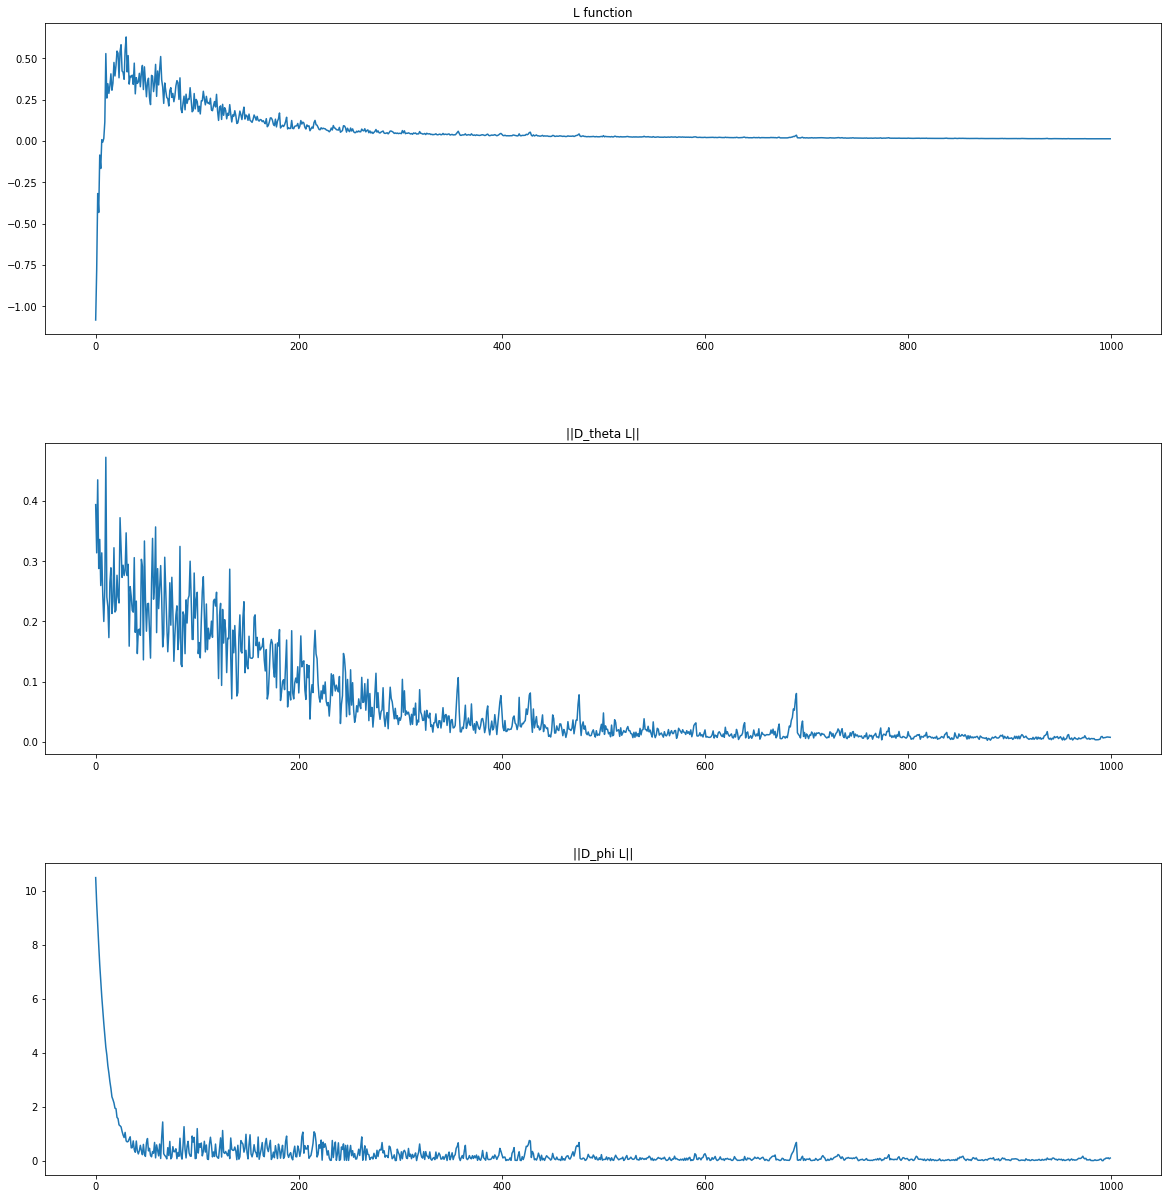

In [1]:
import numpy as np
from matplotlib import pyplot as plt

N, p = 30, 20
np.random.seed(0)
X = np.random.randn(N,p)
Y = 2*np.random.randint(2, size = N) - 1
lamda = 30

theta = 0.1 * np.random.randn(p)
phi = 0.1 * np.random.randn(p)
alpha = 3e-1
beta = 1e-4

epoch = 1000
L_val = []
d_phi_val = []
d_theta_val = []

for _ in range(epoch):
    for __ in range(N):
        k = np.random.randint(N, size=1)
        d_phi_k = Y[k] / (1 + np.exp(Y[k] * ((X[k,:]-phi.reshape(1,-1)) @ theta))) * theta - lamda * phi
        d_theta_k = (-Y[k] / (1 + np.exp(Y[k] * ((X[k,:]-phi.reshape(1,-1)) @ theta)))).reshape(-1,1)*(X[k,:]-phi.reshape(1,-1))
        theta -= alpha * d_theta_k.squeeze()
        phi += beta * d_phi_k.squeeze()
    L_i = np.average(np.log(1 + np.exp(-Y * ((X - phi.reshape(1,-1)) @ theta)))) - lamda/2 * np.linalg.norm(phi, axis=0, ord=2) **2
    d_phi = np.average(Y / (1 + np.exp(Y * ((X-phi.reshape(1,-1)) @ theta)))) * theta - lamda * phi
    d_theta = np.average(( -Y / (1 + np.exp(Y * ((X-phi.reshape(1,-1)) @ theta))) ).reshape(-1,1)*(X-phi.reshape(1,-1)), axis=0)
    L_val.append(L_i)
    d_phi_val.append(d_phi)
    d_theta_val.append(d_theta)

fig, ax = plt.subplots(figsize=(20, 20))
plt.subplots_adjust(left=0.125,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.2,
                    hspace=0.35)
plt.subplot(3, 1, 1)
plt.title("L function")
plt.plot(L_val)
plt.subplot(3, 1, 2)
plt.title("||D_theta L||")
plt.plot(np.linalg.norm(d_theta_val, axis=1, ord=2))
plt.subplot(3, 1, 3)
plt.title("||D_phi L||")
plt.plot(np.linalg.norm(d_phi_val, axis=1, ord=2))
plt.show()


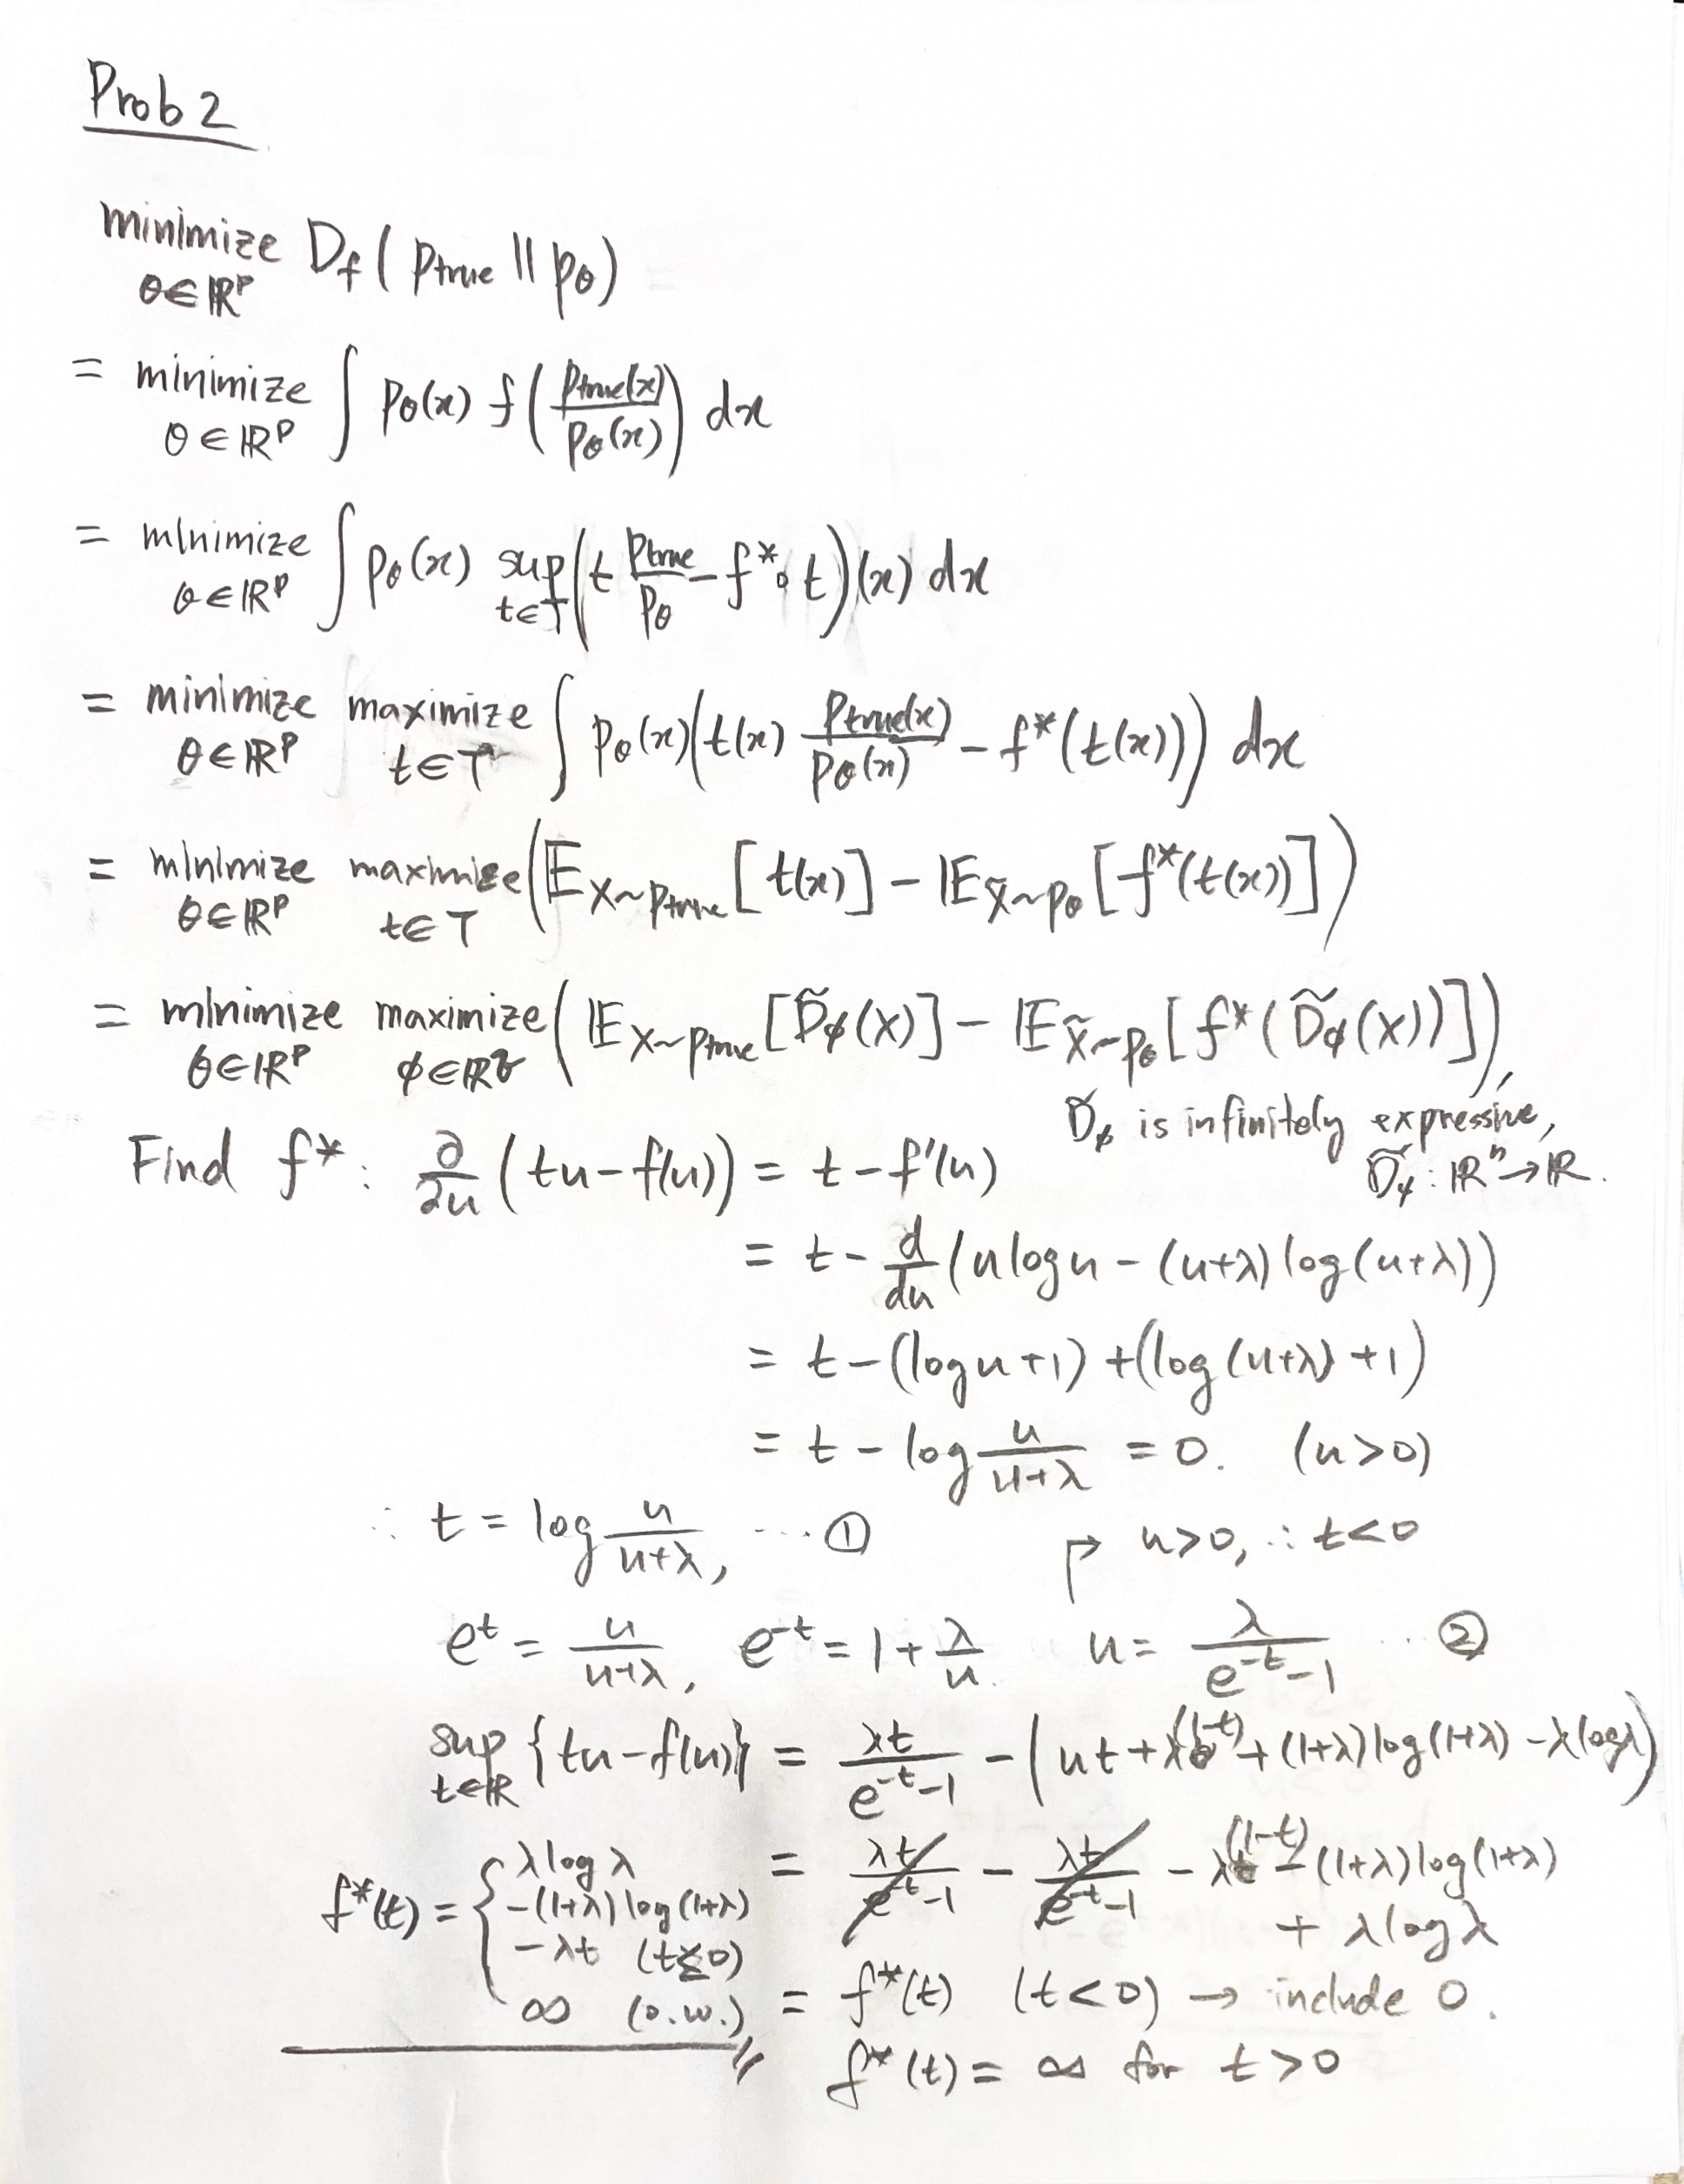

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


"""
Step 0 : Define training configurations
"""

batch_size = 64
learning_rate = 5e-4 
num_epochs = 2000
reg_coeff = 150    # only required for VAE 
device = "cuda:0" if torch.cuda.is_available() else "cpu"


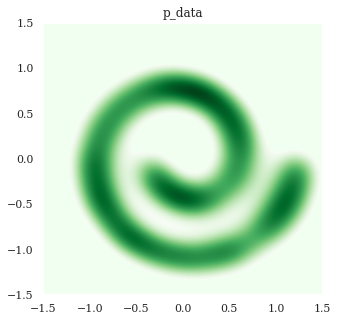

In [2]:
"""
Step 1 : Define custom dataset 
"""

def make_swiss_roll(n_samples=2000, noise = 1.0, dimension = 2, a = 20, b = 5):
    """
    Generate 2D swiss roll dataset 
    """
    t = 2 * np.pi * np.sqrt(np.random.uniform(0.25,4,n_samples))
    
    X = 0.1 * t * np.cos(t)
    Y = 0.1 * t * np.sin(t)
    
    errors = 0.025 * np.random.multivariate_normal(np.zeros(2), np.eye(dimension), size = n_samples)
    X += errors[:, 0]
    Y += errors[:, 1]
    return np.stack((X, Y)).T


def show_data(data, title):
    """
    Plot the data distribution
    """
    sns.set(rc={'axes.facecolor': 'honeydew', 'figure.figsize': (5.0, 5.0)})
    plt.figure(figsize = (5, 5))
    plt.rc('text', usetex = False)
    plt.rc('font', family = 'serif')
    plt.rc('font', size = 10)
    
    g = sns.kdeplot(x=data[:, 0], y=data[:, 1], fill=True, thresh=0.1, levels=1000, cmap="Greens")
    
    g.grid(False)
    plt.margins(0, 0)
    plt.xlim(-1.5,1.5)
    plt.ylim(-1.5,1.5)
    plt.title(title)
    plt.show()


sns.set(rc={'axes.facecolor': 'honeydew', 'figure.figsize': (5.0, 5.0)})
plt.figure(figsize = (5, 5))
plt.rc('text', usetex = False)
plt.rc('font', family = 'serif')
plt.rc('font', size = 10)


data = make_swiss_roll()
g = sns.kdeplot(x=data[:, 0], y=data[:, 1], fill=True, thresh=0.1, levels=1000, cmap="Greens")
g.grid(False)
plt.margins(0, 0)
plt.xlim(-1.5,1.5)
plt.ylim(-1.5,1.5)
plt.title('p_data')
plt.savefig('swiss_roll_true.png')
plt.show()



In [4]:
"""
Step 2 : Define custom dataset and dataloader. 
"""

class SwissRollDataset(Dataset) : 
    def __init__(self, data) : 
        super().__init__()
        self.data = torch.from_numpy(data)
    
    def __len__(self) : 
        return len(self.data)
    
    def __getitem__(self, idx) :
        return self.data[idx]

    
data = make_swiss_roll()
dataset = SwissRollDataset(data)
loader = DataLoader(dataset, batch_size = batch_size, shuffle = True)

In [5]:
"""
Step 3 : Implement models
"""

class Encoder(nn.Module) : 
    def __init__(self) : 
        super(Encoder, self).__init__()
        self.l1 = nn.Linear(2, 128)
        self.a1 = nn.LeakyReLU(0.2) 
        self.l2 = nn.Linear(128, 64)
        self.a2 = nn.Tanh()
        self.l3 = nn.Linear(64, 2)

    
    def forward(self, x) : 
        z = self.a1(self.l1(x.float()))
        z = self.a2(self.l2(z))
        z = self.l3(z)
        return z[:, :1], z[:, 1:]
    

class Decoder(nn.Module) : 
    def __init__(self) :
        super(Decoder, self).__init__()
        self.l1 = nn.Linear(1, 64)
        self.a1 = nn.LeakyReLU(0.2)
        self.l2 = nn.Linear(64, 32)
        self.a2 = nn.Tanh()
        self.l3 = nn.Linear(32, 2)
    
    def forward(self, z) :
        z = z.float().view(-1, 1)
        z = self.a1(self.l1(z))
        z = self.a2(self.l2(z))
        return self.l3(z)


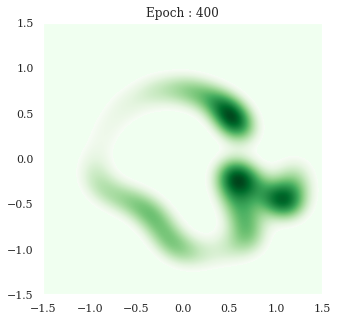

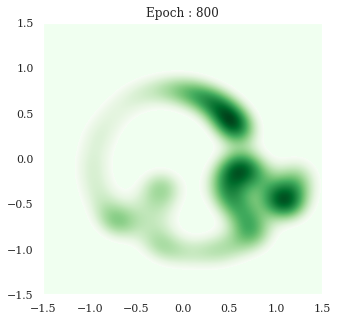

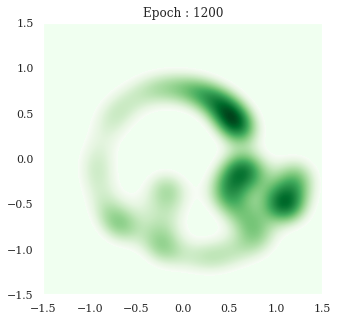

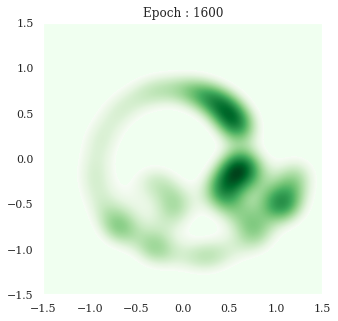

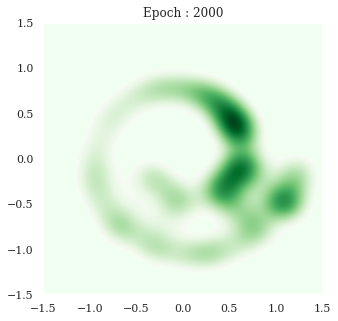

In [6]:
"""
Step 4 : Train models
""" 
# Network Instances
encoder = Encoder().to(device)
decoder = Decoder().to(device)

# Optimizers 
optimizer = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=learning_rate)

# log_p_theta_(z|x) (reconstruction loss)
def log_p(x_hat, x):
    mse = nn.MSELoss().to(device)
    return -mse(x_hat, x)

# reparametrization trick
def reparametrization_trick(mu, log_std):
    z = torch.randn_like(mu)*log_std.exp()+mu
    return z

def kl_div(mu, log_std):
    kl = -log_std - 0.5 + (torch.exp(2 * log_std) + mu ** 2) * 0.5
    kl = kl.sum(1).mean()
    return kl


for epoch in range(num_epochs) : 
    for batch_idx, x in enumerate(loader) : 
        if device == "cpu" :
            x = x.to(device).type(torch.FloatTensor)
        else :
            x = x.to(device).type(torch.cude.FloatTensor)
        
        mu, log_std = encoder(x)
        z = reparametrization_trick(mu, log_std)
        x_hat = decoder(z)

        x = x.view(x.shape[0], -1)
        x_hat = x_hat.view(x_hat.shape[0], -1)
        recon_loss = -log_p(x_hat, x)
        regularizer = kl_div(mu, log_std)

        loss = recon_loss * reg_coeff + regularizer

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
    
    # Visualize the intermediate result
    if (epoch + 1) % (num_epochs // 5) == 0:
        z = torch.randn(3000, 1).to(device)
        with torch.no_grad():
            samples = decoder(z).cpu().detach()
        
        sns.set(rc={'axes.facecolor': 'honeydew', 'figure.figsize': (5.0, 5.0)})
        plt.figure(figsize = (5, 5))
        plt.rc('text', usetex = False)
        plt.rc('font', family = 'serif')
        plt.rc('font', size = 10)

        g = sns.kdeplot(x=samples[:, 0], y=samples[:, 1], fill=True, thresh=0.1, levels=1000, cmap="Greens")

        g.grid(False)
        plt.margins(0, 0)
        plt.xlim(-1.5,1.5)
        plt.ylim(-1.5,1.5)
        plt.title(f"Epoch : {epoch + 1}")
        plt.show()


In [7]:
"""
Step 2 : Define custom dataset and dataloader. 
"""

class SwissRollDataset(Dataset) : 
    def __init__(self, data) : 
        super().__init__()
        self.data = torch.from_numpy(data)
    
    def __len__(self) : 
        return len(self.data)
    
    def __getitem__(self, idx) :
        return self.data[idx]

    
data = make_swiss_roll()
dataset = SwissRollDataset(data)
loader = DataLoader(dataset, batch_size = batch_size, shuffle = True)


In [8]:
"""
Step 3 : Implement models
"""
class Generator(nn.Module) : 
    def __init__(self) :
        super(Generator, self).__init__()
        self.l1 = nn.Linear(1, 32)
        self.l2 = nn.Linear(32, 2)
        self.activation = nn.Tanh()
        
    
    def forward(self, z) :
        z = z.float().view(-1, 1)
        out1 = self.activation(self.l1(z))
        return self.l2(out1)



class Discriminator(nn.Module) : 
    def __init__(self) : 
        super(Discriminator, self).__init__()
        self.l1 = nn.Linear(2, 128)
        self.l2 = nn.Linear(128, 128)
        self.l3 = nn.Linear(128, 1)
        self.activation = nn.Tanh() 
        self.sigmoid = nn.Sigmoid()
    

    def forward(self, x) : 
        out1 = self.activation(self.l1(x.float()))
        out2 = self.activation(self.l2(out1))
        return self.sigmoid(self.l3(out2))


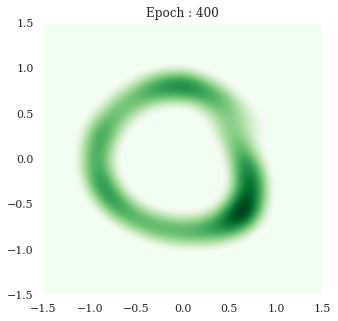

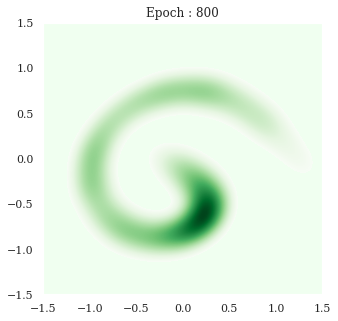

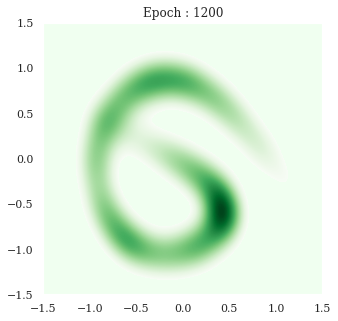

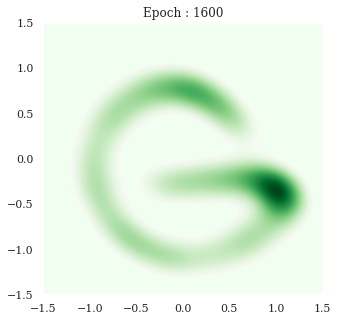

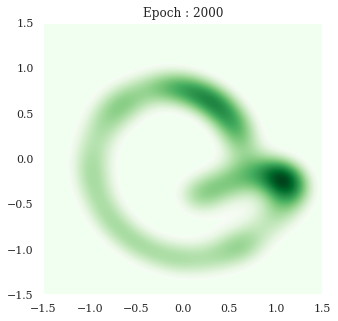

In [9]:
"""
Step 4 : Train models
""" 
netG = Generator().to(device)
netD = Discriminator().to(device)

# Optimizers 
optimizer_G = torch.optim.Adam(netG.parameters(), lr = learning_rate)
optimizer_D = torch.optim.Adam(netD.parameters(), lr = learning_rate)

# training loop
loss_netD, loss_netG = [], []


for epoch in range(num_epochs) : 
    for batch_idx, x in enumerate(loader) : 
        x = x.to(device) 
        
        # Train Discriminator network 
        optimizer_D.zero_grad()
        z = torch.randn(x.shape[0], 1).to(device)
        loss_D = torch.mean(-torch.log(netD(x))-torch.log(1-netD(netG(z))))
        loss_D.backward()
        optimizer_D.step()
        loss_netD.append(-loss_D.item())
        
        # Train Generator network 
        optimizer_G.zero_grad()
        new_z =  torch.randn(x.shape[0], 1).to(device)
        loss_G = torch.mean(torch.log(1-netD(netG(new_z))))
        loss_G.backward()
        optimizer_G.step()
        loss_netG.append(loss_G.item())    
    
    
    # Visualize the intermediate result
    if (epoch + 1) % (num_epochs // 5) == 0:
        z = torch.randn(3000, 1).to(device)
        with torch.no_grad():
            samples = netG(z).cpu().detach()
        
        sns.set(rc={'axes.facecolor': 'honeydew', 'figure.figsize': (5.0, 5.0)})
        plt.figure(figsize = (5, 5))
        plt.rc('text', usetex = False)
        plt.rc('font', family = 'serif')
        plt.rc('font', size = 10)

        g = sns.kdeplot(x=samples[:, 0], y=samples[:, 1], fill=True, thresh=0.1, levels=1000, cmap="Greens")

        g.grid(False)
        plt.margins(0, 0)
        plt.xlim(-1.5,1.5)
        plt.ylim(-1.5,1.5)
        plt.title(f"Epoch : {epoch + 1}")
        plt.show()